In [1]:
%matplotlib inline
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from timeit import default_timer as timer
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, ArrayType
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start
        
def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']
punct_regex_expression = "[!\"#$%&()*+-.\/\\:;<=>?@[\]^_`{|}\\t\\n\',~—]"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setting up the spark cluster

In [4]:
conf = (SparkConf().setMaster("local[*]")
                .setAppName("SparkVectorizer")
                .set('spark.driver.memory', '300G')
                .set('spark.driver.maxResultSize', '20G')
                .set('spark.network.timeout', '7200s')
                .set('spark.local.dir', './u01/tmp'))
#                .set('spark.executor.cores', '20'))

sc = SparkContext(conf=conf)
# sc.setLogLevel("ERROR")
spark = SparkSession(sc)
print(sc._conf.getAll()) # check context settings

[('spark.driver.maxResultSize', '20G'), ('spark.driver.port', '33553'), ('spark.driver.host', 'd05ea504c36e'), ('spark.executor.id', 'driver'), ('spark.app.id', 'local-1627680337762'), ('spark.local.dir', './u01/tmp'), ('spark.rdd.compress', 'True'), ('spark.network.timeout', '7200s'), ('spark.app.name', 'SparkVectorizer'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.memory', '300G'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.startTime', '1627680336855')]


In [5]:
def read_data(spark, parquet_path, persist_flag=True):
    data = spark.read.parquet(parquet_path)
    if persist_flag:
        data.persist(StorageLevel.MEMORY_ONLY)
        data.head(0)
    return data

def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS, persist_flag=True):
    data = data.na.drop(subset=[column_name])
    data = data.withColumn(column_name,f.lower(f.col(column_name)))
    data = data.withColumn(column_name,f.regexp_replace(f.col(column_name), """[!"#$%&()*+-.\/\\:;<=>?@\[\]^_`{|}\t\n\',~—]""", ' '))
    data = data.withColumn(column_name,f.trim(f.col(column_name)))
    tokenizer = Tokenizer(inputCol=column_name, outputCol="words")
    wordsData = tokenizer.transform(data)                  
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=STOPWORDS)
    cleaned = stopwordsRemover.transform(wordsData)
    if persist_flag:
        cleaned.persist(StorageLevel.MEMORY_ONLY)
        cleaned.head(0)
    return data, cleaned

def hashing_vectorizer(data, persist_flag):
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2**20)
    featurizedData = hashingTF.transform(data)
    if persist_flag:
        featurizedData.persist(StorageLevel.MEMORY_ONLY)
        featurizedData.head(0)
    return featurizedData

def tfidf_transformer(data, persist_flag):
    idf = IDF(inputCol="rawFeatures", outputCol="finalFeatures").fit(data)
    rescaledData = idf.transform(data)
    if persist_flag:
        rescaledData.persist(StorageLevel.MEMORY_ONLY)
        rescaledData.head(0)
    return rescaledData

def execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(spark, parquet_path, persist_flag)
    sample_record["data_read"]=timer.elapsed

    with SimpleTimer() as timer:
        data, cleaned = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS, persist_flag)
    sample_record["data_preprocessing"]=timer.elapsed
    
    with SimpleTimer() as timer:
        X = hashing_vectorizer(cleaned, persist_flag)
    sample_record["hashing_vectorizer"]=timer.elapsed
    
    with SimpleTimer() as timer:
        data_transformed = tfidf_transformer(X, persist_flag=True)
    sample_record["tfidf_transformer"]=timer.elapsed
    
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, data_transformed, sample_record
    
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    """
    Main function to perform the performance sweep
    """

    overall_perf_result = {}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, data_transformed, sample_record = execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path=result_path, persist_flag=persist_flag)                
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=  data.count()
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)
    

In [6]:
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_persist.pkl"

In [7]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 4210063024s
Workers:1, Sample Run:0, Finished preprocessing data in 950437095s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 135317140s
Workers:1, Sample Run:0, Finished fitting IDF Transformer in 234548070913s


 20%|██        | 1/5 [04:00<16:02, 240.63s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 239844051491s
Workers:1, Sample Run:1, Finished loading data in 118133286s
Workers:1, Sample Run:1, Finished preprocessing data in 213335510s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 51876862s
Workers:1, Sample Run:1, Finished fitting IDF Transformer in 229511731880s


 40%|████      | 2/5 [07:51<11:44, 234.67s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 229895259452s
Workers:1, Sample Run:2, Finished loading data in 83936716s
Workers:1, Sample Run:2, Finished preprocessing data in 177519414s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 46565680s
Workers:1, Sample Run:2, Finished fitting IDF Transformer in 215371016951s


 60%|██████    | 3/5 [11:27<07:32, 226.22s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 215679588381s
Workers:1, Sample Run:3, Finished loading data in 82812325s
Workers:1, Sample Run:3, Finished preprocessing data in 146123202s
Workers:1, Sample Run:3, Finished fitting HashVectorizer in 37916527s
Workers:1, Sample Run:3, Finished fitting IDF Transformer in 213455088715s


 80%|████████  | 4/5 [15:01<03:41, 221.47s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 213722173634s
Workers:1, Sample Run:4, Finished loading data in 70889719s
Workers:1, Sample Run:4, Finished preprocessing data in 141334894s
Workers:1, Sample Run:4, Finished fitting HashVectorizer in 36772705s
Workers:1, Sample Run:4, Finished fitting IDF Transformer in 208912941751s


100%|██████████| 5/5 [18:31<00:00, 222.23s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 209162169856s
CPU times: user 460 ms, sys: 165 ms, total: 625 ms
Wall time: 18min 31s


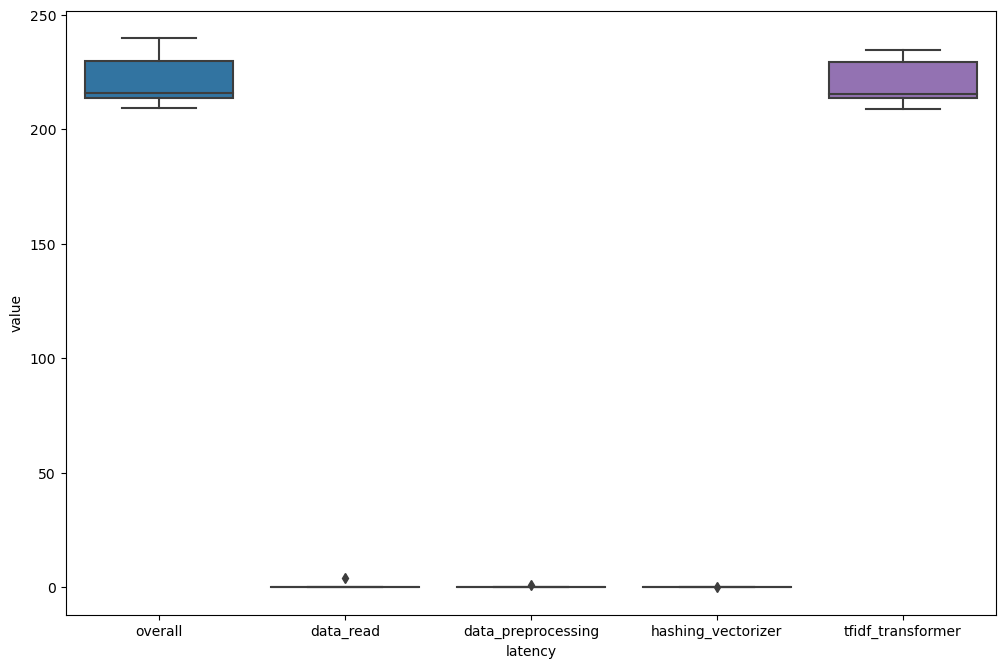

In [8]:
data, melt_data = visualize_data(result_path)    

In [9]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupy

sample_run                     overall                  data_read  \
                mean       std count        mean        std count      mean   
n_workers                                                                     
1                  2  1.581139     5  221.660649  12.781328     5  0.913167   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          1.843105     5            0.32575  ...     5            0.06169   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
1          0.041629     5         220.35977  11.05281     5  7004147  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

### We can run the exact same pipeline without the intermediate persists. But this apparently runs faster.

  0%|          | 0/5 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 62494373s
Workers:1, Sample Run:0, Finished preprocessing data in 106825483s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 14128796s
Workers:1, Sample Run:0, Finished fitting IDF Transformer in 109276726185s


 20%|██        | 1/5 [01:49<07:19, 109.97s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 109460858709s
Workers:1, Sample Run:1, Finished loading data in 63717683s
Workers:1, Sample Run:1, Finished preprocessing data in 107238322s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 14754207s
Workers:1, Sample Run:1, Finished fitting IDF Transformer in 109420502144s


 40%|████      | 2/5 [03:40<05:30, 110.05s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 109606640748s
Workers:1, Sample Run:2, Finished loading data in 62566593s
Workers:1, Sample Run:2, Finished preprocessing data in 111943822s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 15521925s
Workers:1, Sample Run:2, Finished fitting IDF Transformer in 109575155048s


 60%|██████    | 3/5 [05:30<03:40, 110.17s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 109765352503s
Workers:1, Sample Run:3, Finished loading data in 60910356s
Workers:1, Sample Run:3, Finished preprocessing data in 100898732s
Workers:1, Sample Run:3, Finished fitting HashVectorizer in 14551743s
Workers:1, Sample Run:3, Finished fitting IDF Transformer in 111749026290s


 80%|████████  | 4/5 [07:22<01:51, 111.06s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 111925610767s
Workers:1, Sample Run:4, Finished loading data in 60321329s
Workers:1, Sample Run:4, Finished preprocessing data in 107452338s
Workers:1, Sample Run:4, Finished fitting HashVectorizer in 14302423s
Workers:1, Sample Run:4, Finished fitting IDF Transformer in 110608201544s


100%|██████████| 5/5 [09:14<00:00, 110.82s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 110790443080s


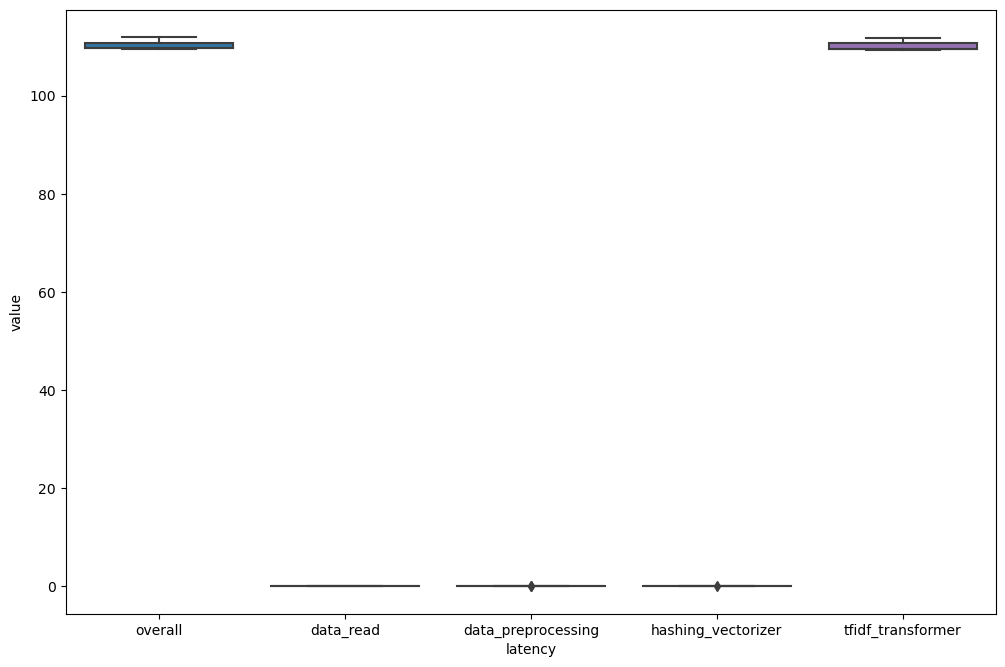

CPU times: user 504 ms, sys: 129 ms, total: 633 ms
Wall time: 9min 14s


sample_run                     overall                 data_read  \
                mean       std count        mean       std count      mean   
n_workers                                                                    
1                  2  1.581139     5  110.309781  1.043242     5  0.062002   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.001371     5           0.106872  ...     5           0.014652   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
1          0.000542     5        110.125922  1.047516     5  7004147  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

In [11]:
%%time
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_nonpersist.pkl"
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=False)
data, melt_data = visualize_data(result_path) 
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy